In [1]:
!pip install openai
!pip install pandas faiss-cpu numpy
!pip install scikit-learn matplotlib
!pip install plotly
!pip install --upgrade nbformat




  Using cached openai-0.27.8-py3-none-any.whl (73 kB)
  Using cached requests-2.31.0-py3-none-any.whl (62 kB)
  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)
  Using cached aiohttp-3.8.4-cp310-cp310-macosx_11_0_arm64.whl (336 kB)
  Using cached charset_normalizer-3.1.0-cp310-cp310-macosx_11_0_arm64.whl (123 kB)
  Using cached idna-3.4-py3-none-any.whl (61 kB)
  Using cached urllib3-2.0.3-py3-none-any.whl (123 kB)
  Using cached certifi-2023.5.7-py3-none-any.whl (156 kB)
  Using cached attrs-23.1.0-py3-none-any.whl (61 kB)
  Using cached multidict-6.0.4-cp310-cp310-macosx_11_0_arm64.whl (29 kB)
  Using cached async_timeout-4.0.2-py3-none-any.whl (5.8 kB)
  Using cached yarl-1.9.2-cp310-cp310-macosx_11_0_arm64.whl (62 kB)
  Using cached frozenlist-1.3.3-cp310-cp310-macosx_11_0_arm64.whl (34 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
  Using cached pandas-2.0.2-cp310-cp310-macosx_11_0_arm64.whl (10.8 MB)
  Using cached faiss_cpu-1.7.4-cp310-cp310-macosx_11_0_arm64.wh

In [2]:
import openai
import pandas as pd
import numpy as np
import faiss
import os
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ast
import plotly.express as px





In [3]:
# Set your API key
openai.api_key = ## your api key here

file_name = 'scopus'
input_data_path = os.path.join('.', 'data', f'{file_name}.csv')
embeddings_path = os.path.join('.', 'emb_data', f'emb_{file_name}.csv')

vector_store_path = os.path.join('.', 'vector_store')


In [4]:
def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']


In [5]:

if(os.path.exists(embeddings_path)):
    print("Embeddings file already exists")
    df = pd.read_csv(embeddings_path)
    df['Abstract_embedding'] = df['Abstract_embedding'].apply(lambda x: ast.literal_eval(x))


    print(df.shape)
    print("len of embedding: ", len(df['Abstract_embedding'].iloc[0]))
    print("Type of embedding: ", type(df['Abstract_embedding'].iloc[0]))
    print("Type of value in embeddings: ", type(df['Abstract_embedding'].iloc[0][0]))

else:
    df = pd.read_csv(input_data_path)
    #get only a subset of the data for now
    #df = df.head(10)
    print(df.shape)
    # Get abstract embeddings
    df['Abstract_embedding'] = df['Abstract'].apply(get_embedding)
    print("Len of embedding: ", len(df['Abstract_embedding'].iloc[0]))

    # Save embeddings
    df.to_csv(embeddings_path, index=False)



Embeddings file already exists
(2000, 16)
len of embedding:  1536
Type of embedding:  <class 'list'>
Type of value in embeddings:  <class 'float'>


## TSNE visualization

In [30]:
embeddings = df['Abstract_embedding'].tolist()


# Transform embeddings to numpy array
X = np.array(embeddings)

# Use t-SNE to reduce dimensionality to 3
tsne = TSNE(n_components=3)
X_tsne = tsne.fit_transform(X)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5) # 5 clusters, adjust as needed
X_clustered = kmeans.fit_predict(X_tsne)

# Create DataFrame for plotly
df_plotly = pd.DataFrame({'x': X_tsne[:, 0], 'y': X_tsne[:, 1], 'z': X_tsne[:, 2], 'cluster': X_clustered})

# Create a 3D plot
fig = px.scatter_3d(df_plotly, x='x', y='y', z='z', color='cluster', opacity=1)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()


/Users/farazkhoshbakhtian/OpenAI/dair_project/.conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



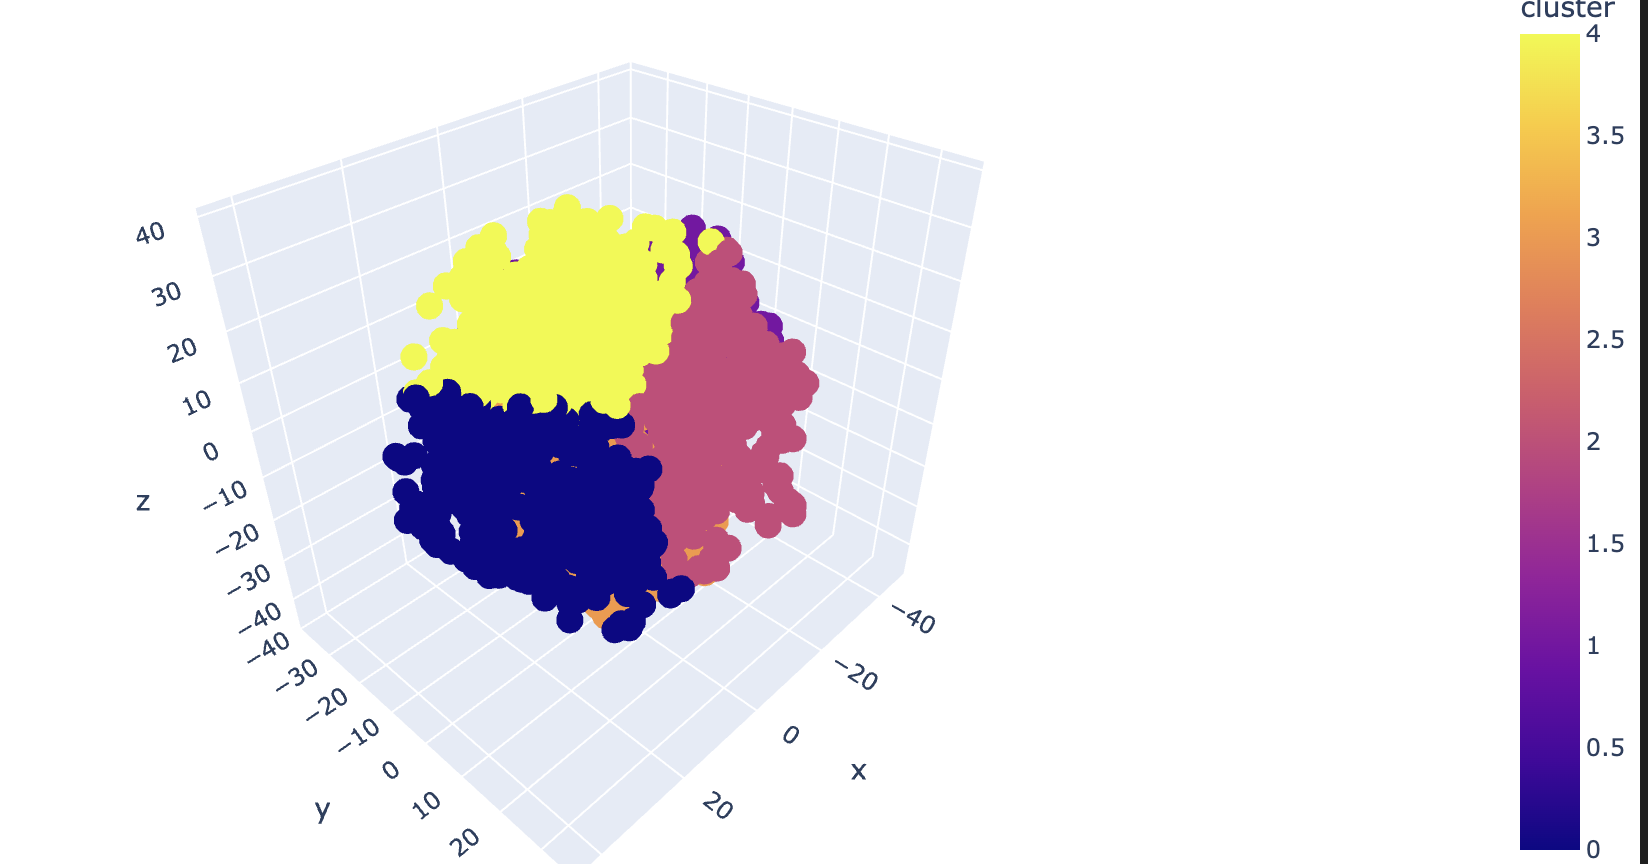

## FAISSE vectordatabase

In [31]:
index_file_path = os.path.join(vector_store_path, f'{file_name}.index')
pkl_file_path = os.path.join(vector_store_path, f'{file_name}.pkl')


In [35]:
# Convert embedding list to numpy array
df['Abstract_embedding'] = df['Abstract_embedding'].apply(lambda x: np.array(x))

# Convert your embeddings into a matrix for FAISS
embedding_matrix = np.vstack(df['Abstract_embedding'].values)

# Dimension of the vector
d = len(df['Abstract_embedding'][0])

# Building the index
index = faiss.IndexFlatL2(d)
index.add(embedding_matrix.astype('float32'))

# Save the index
faiss.write_index(index, index_file_path)

# Save the DataFrame (we will use it later)
df.to_pickle(pkl_file_path)

In [36]:
# Load the saved index and DataFrame
index = faiss.read_index(index_file_path)
df = pd.read_pickle(pkl_file_path)

In [37]:
new_entry = "Machine learning paper about imbalanced data using modelling tools such as trivial autoencoder, generative adverserial networks"

# Get the embedding of the new entry
new_entry_embedding = get_embedding(new_entry)

In [38]:
# The new abstract embedding
new_embedding = np.array(new_entry_embedding)

# Number of nearest neighbors you want to find
k = 5

# Search the index
D, I = index.search(new_embedding.reshape(1, -1).astype('float32'), k)

# D contains the distances and I contains the indices of the nearest neighbors
# I is a 2D array where each row contains the indices of the nearest neighbors of a query vector

# Get the details of the nearest neighbors
for idx in I[0]:
    paper_details = df.iloc[idx]
    #print(paper_details)
    print(paper_details['Title'])
    authors = paper_details['Authors']
    authors = authors.split(',')
    print("Author(s):  ", authors)
    print("DOI: ", paper_details['DOI'])


Synthesizing credit data using autoencoders and generative adversarial networks
Author(s):   ['Oreski G.']
DOI:  10.1016/j.knosys.2023.110646
Balancing Imbalanced Datasets Using Generative Adversarial Neural Networks
Author(s):   ['Divovic P.', ' Obradovic P.', ' Misic M.']
DOI:  10.1109/TELFOR52709.2021.9653392
Prospects for generative - Adversarial networks in network traffic classification tasks
Author(s):   ['Asyaev G.D.']
DOI:  10.1088/1742-6596/2096/1/012174
Leveraging Autoencoder and Focal Loss for Imbalanced Data Classification
Author(s):   ['Xu Y.', ' Ye H.', ' Zhang N.', ' Du G.']
DOI:  10.1109/ITME56794.2022.00110
On oversampling imbalanced data with deep conditional generative models
Author(s):   ['Fajardo V.A.', ' Findlay D.', ' Jaiswal C.', ' Yin X.', ' Houmanfar R.', ' Xie H.', ' Liang J.', ' She X.', ' Emerson D.B.']
DOI:  10.1016/j.eswa.2020.114463
